In [2]:
import pandas as pd
import itertools
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import roc_auc_score, auc, roc_curve, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.over_sampling import SMOTE

In [3]:
df = pd.read_csv('../data/creditcard.csv')

# standard scale Amount
ss = StandardScaler()
df['normAmount'] = ss.fit_transform(pd.DataFrame(df['Amount']))

# drop Time and Amount
df.drop(columns = ['Time','Amount'], inplace = True)

X = df.drop(columns = 'Class')
y = df['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

# create SMOTE
sm = SMOTE(random_state = 42)
X_train_sm, y_train_sm = sm.fit_sample(X_train, y_train.ravel())


In [16]:
# datset with stratify
X_train_sf, X_test_sf, y_train_sf, y_test_sf = train_test_split(X, y, stratify = y, random_state = 42)


X_train_sm_sf, y_train_sm_sf = sm.fit_sample(X_train_sf, y_train_sf.ravel())


In [5]:
def plot_confusion_matrix(cm,title):
    plt.figure(figsize = (8,8))
    plt.imshow(cm, interpolation='nearest', cmap='Blues')
    plt.xticks(ticks = [0,1],
               labels = ['predict normal','predict fraud'], 
               size = 12)
    plt.yticks(ticks = [0,1],
               labels = ['actual normal','actual fraud'], 
               size = 12)

    # cm.max() shows the larger value for class 0 and 1
    thresh = cm.max() / 2.
    
    # cm.shape = (2,2), i,j shows (0,0,1,1), (1,0,1,0)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        # cm[i,j] only works with confusion_matrix without pd.DataFrame, it shows each data in matrix
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label', size =20)
    plt.xlabel('Predicted label', size = 20)
    plt.title(title, size = 30)

In [6]:
def feature_importance(model,df = X_train_sm):
    predictors = [x for x in df.columns]
    feat_imp = pd.Series(model.feature_importances_,predictors).sort_values(ascending = False)
    
    plt.figure(figsize = (8,6))
    feat_imp.plot(kind = 'bar')
    plt.ylabel('Feature Importance Score')
    plt.title('Feature Importance', size = 20);

In [12]:
def model_vis(model, index):
    prediction_train = model.predict(X_train)
    prediction_test = model.predict(X_test)
    
    cnf_train = confusion_matrix(y_train, prediction_train)
    cnf_test = confusion_matrix(y_test, prediction_test)
    
    recall_train = cnf_train[1,1] / (cnf_train[1,1] + cnf_train[1,0])
    recall_test = cnf_test[1,1] / (cnf_test[1,1] + cnf_test[1,0])
    
    precision_train = cnf_train[1,1] / (cnf_train[1,1] + cnf_train[0,1])
    precision_test = cnf_test[1,1] / (cnf_test[1,1] + cnf_test[0,1])
    
    roc_train = roc_auc_score(y_train, prediction_train)
    roc_test = roc_auc_score(y_test, prediction_test)

    result = {
        'false_positive_test' : cnf_test[0,1],
        'false_negative_test' : cnf_test[1,0],
        'recall_train' : recall_train, 
        'recall_test' : recall_test,
        'precision_train' : precision_train, 
        'precision_test' : precision_test,
        'roc_train' : roc_train,
        'roc_test' : roc_test,
    }
    
    output = pd.DataFrame(result,index = [index])
    
    plot_train = plot_confusion_matrix(cnf_train,f'{index} train')
    plot_test = plot_confusion_matrix(cnf_test,f'{index} test')
    
    feature_chart = feature_importance(model)
    
    return output

# Baseline

In [8]:
extra_tree = ExtraTreesClassifier(random_state= 42)
model = extra_tree.fit(X_train_sm, y_train_sm.ravel())

,false_positive_test,false_negative_test,recall_train,recall_test,precision_train,precision_test,roc_train,roc_test
default,15,19,1.0,0.831858,1.0,0.862385,1.0,0.915824


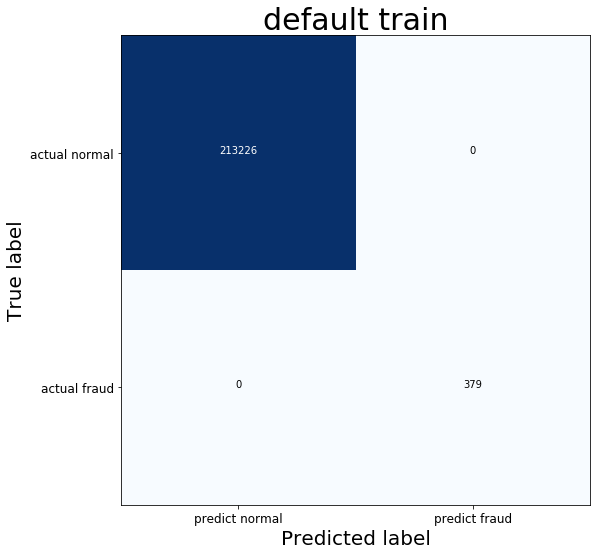

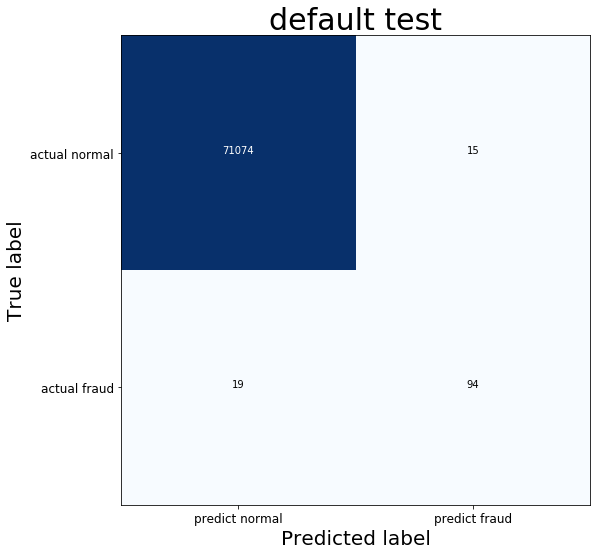

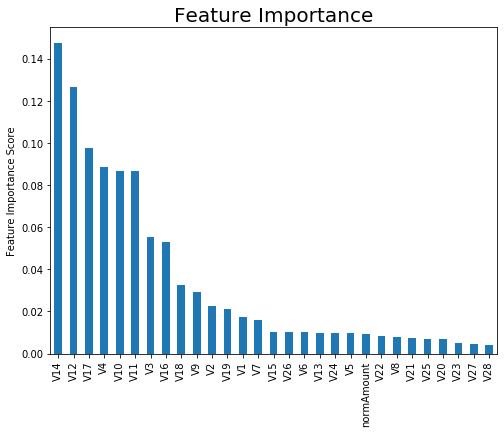

In [13]:
model_vis(model,'default')

,false_positive_test,false_negative_test,recall_train,recall_test,precision_train,precision_test,roc_train,roc_test
default stratify,4,7,0.960422,0.938053,0.981132,0.963636,0.980195,0.968998


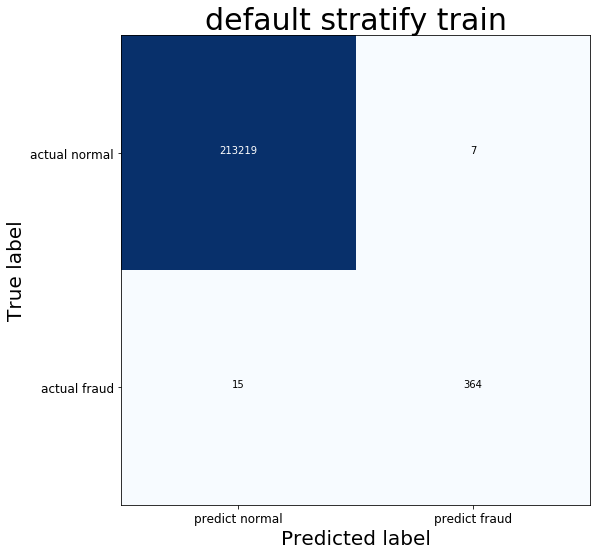

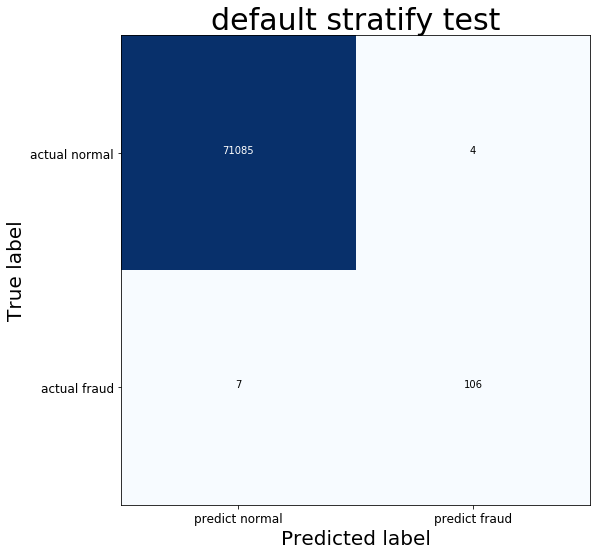

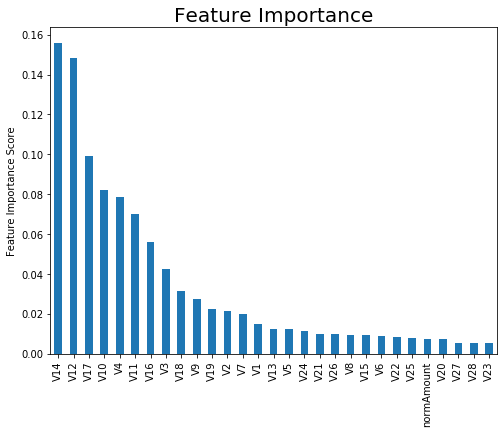

In [17]:
# model with stratify
model_sf = extra_tree.fit(X_train_sm_sf, y_train_sm_sf.ravel())
model_vis(model_sf, 'default stratify')

# Gridsearch params

In [ ]:
# n_estimators
# max_depth
# max_feature
# min_samples_split, min_samples_leaf
# bootstrap, class_weight

## step 1: bootstrap, class_weight

In [22]:
grid_params = {
    'bootstrap':[True, False],
    'class_weight': ['balanced','balanced_subsample',None]
}

gs1 = GridSearchCV(ExtraTreesClassifier(random_state = 42),
                   param_grid=grid_params,
                   cv = 5, 
                   n_jobs=4, 
                   verbose=5)

In [23]:
gs1.fit(X_train_sm_sf,y_train_sm_sf.ravel())
gs1.best_params_, gs1.best_score_

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:  3.4min
[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:  9.7min remaining:    0.0s
[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:  9.7min finished


({'bootstrap': False, 'class_weight': 'balanced'}, 0.9998991727695554)

In [33]:
model_grid = ExtraTreesClassifier(class_weight='balanced', random_state=42)
model = model_grid.fit(X_train_sm_sf,y_train_sm_sf.ravel())

,false_positive_test,false_negative_test,recall_train,recall_test,precision_train,precision_test,roc_train,roc_test
gridsearch 1,4,7,0.960422,0.938053,0.981132,0.963636,0.980195,0.968998


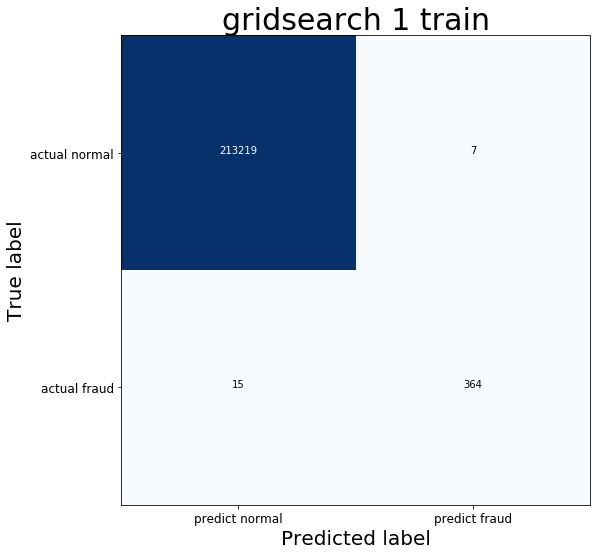

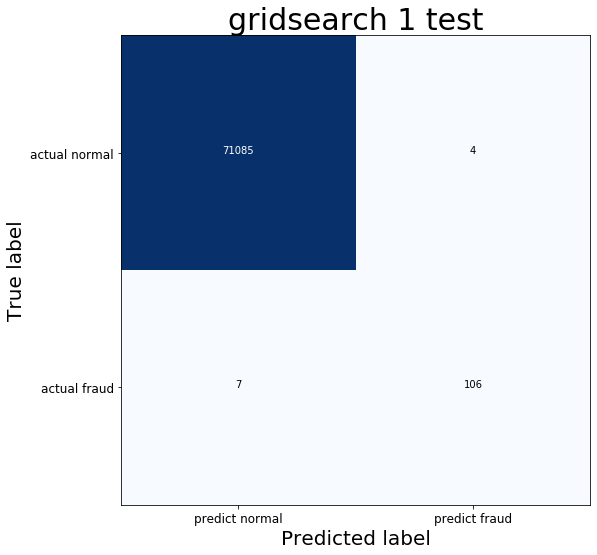

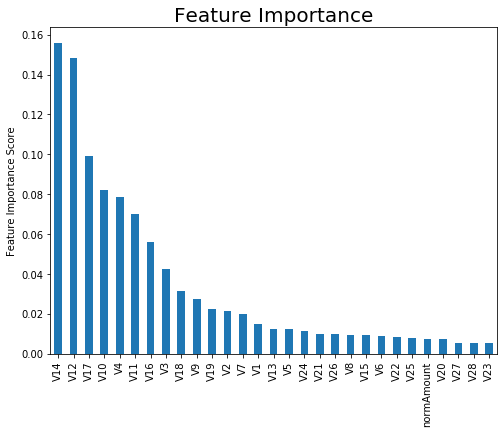

In [34]:
model_vis(model, 'gridsearch 1')

## step 2: min_samples_split, min_samples_leaf

In [24]:
grid_params = {
    'min_samples_split': range(100, 1101, 200),
    'min_samples_leaf': range(5,106,20)
}

gs2 = GridSearchCV(ExtraTreesClassifier(bootstrap = False, 
                                        class_weight = 'balanced',
                                        random_state = 42),
                   param_grid=grid_params,
                   cv = 5, 
                   n_jobs=4, 
                   verbose=5)

In [26]:
gs2.fit(X_train_sm_sf, y_train_sm_sf.ravel())
gs2.best_params_, gs2.best_score_

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:  1.9min
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed: 10.8min
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed: 34.8min
[Parallel(n_jobs=4)]: Done 180 out of 180 | elapsed: 42.1min finished


({'min_samples_leaf': 5, 'min_samples_split': 100}, 0.9990831752728269)

In [30]:
grid_params = {
    'min_samples_split': range(70, 111, 10),
    'min_samples_leaf': range(1,11,2)
}

gs2_1 = GridSearchCV(ExtraTreesClassifier(bootstrap = False, 
                                        class_weight = 'balanced',
                                        random_state = 42),
                   param_grid=grid_params,
                   cv = 5, 
                   n_jobs=4, 
                   verbose=5)

In [31]:
gs2_1.fit(X_train_sm_sf, y_train_sm_sf.ravel())
gs2_1.best_params_, gs2.best_score_

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:  4.0min
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed: 20.9min
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed: 40.7min finished


({'min_samples_leaf': 1, 'min_samples_split': 70}, 0.9990831752728269)

In [32]:
gs2_1.best_params_, gs2_1.best_score_

({'min_samples_leaf': 1, 'min_samples_split': 70}, 0.9997373800477423)

In [42]:
model_grid = ExtraTreesClassifier(min_samples_leaf=1,
                                  min_samples_split=70,
                                  class_weight='balanced', 
                                  random_state=42)
model = model_grid.fit(X_train_sm_sf,y_train_sm_sf.ravel())

,false_positive_test,false_negative_test,recall_train,recall_test,precision_train,precision_test,roc_train,roc_test
gridsearch 2,12,7,0.960422,0.938053,0.943005,0.898305,0.980159,0.968942


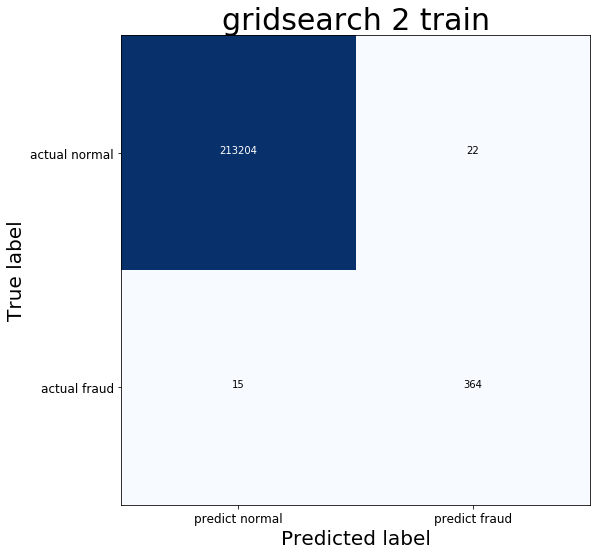

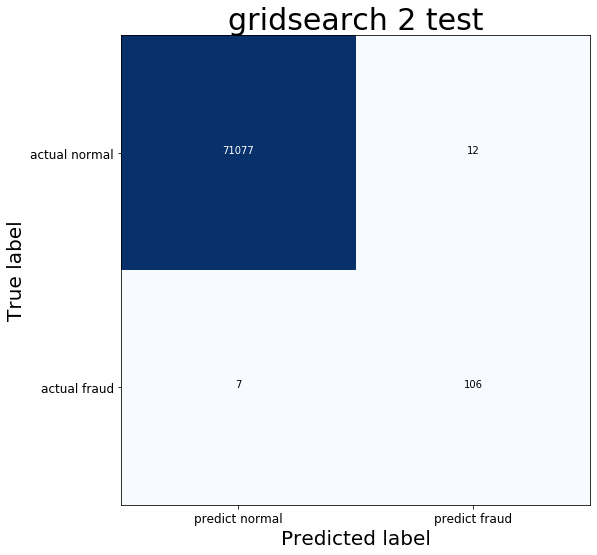

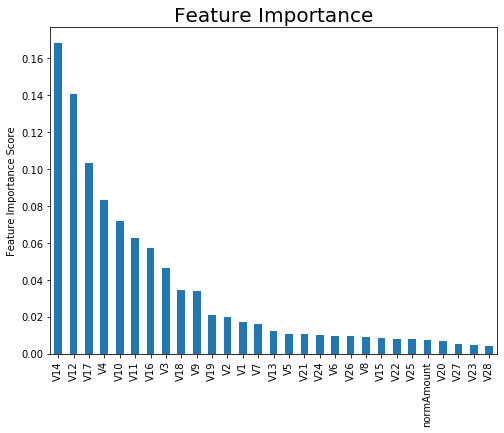

In [43]:
model_vis(model,'gridsearch 2')

- none of the tuning perform better than default

## step 3: max_depth

In [37]:
grid_params = {
    'max_depth': range(10,201,20)
}

gs3 = GridSearchCV(ExtraTreesClassifier(bootstrap = False, 
                                        class_weight = 'balanced',
                                        random_state = 42),
                   param_grid=grid_params,
                   cv = 5, 
                   n_jobs=4, 
                   verbose=5)

In [38]:
gs3.fit(X_train_sm_sf, y_train_sm_sf.ravel())
gs3.best_params_, gs3.best_score_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:  2.3min
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed: 12.4min finished


({'max_depth': 50}, 0.9999015176003759)

In [44]:
model_grid = ExtraTreesClassifier(max_depth = 50,
                                  class_weight='balanced', 
                                  random_state = 42)
model = model_grid.fit(X_train_sm_sf,y_train_sm_sf.ravel())

,false_positive_test,false_negative_test,recall_train,recall_test,precision_train,precision_test,roc_train,roc_test
gridsearch 3,4,7,0.960422,0.938053,0.981132,0.963636,0.980195,0.968998


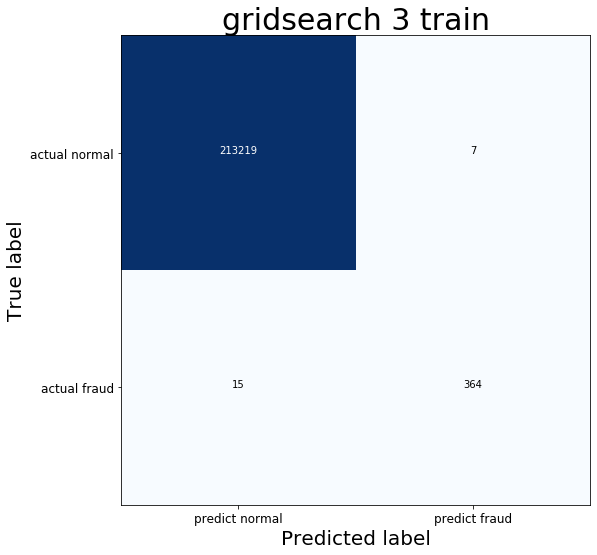

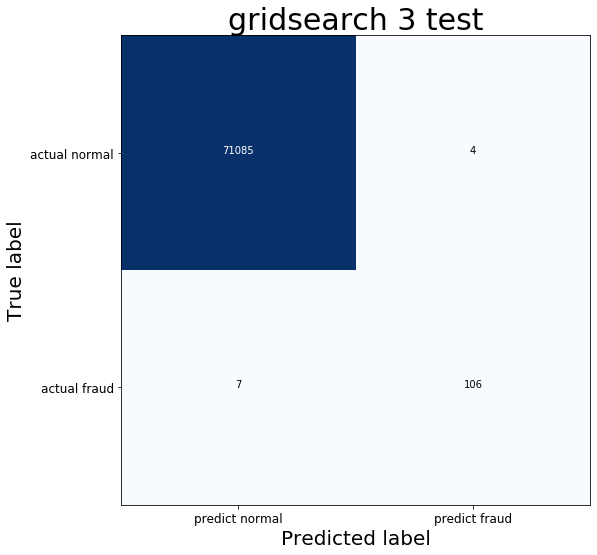

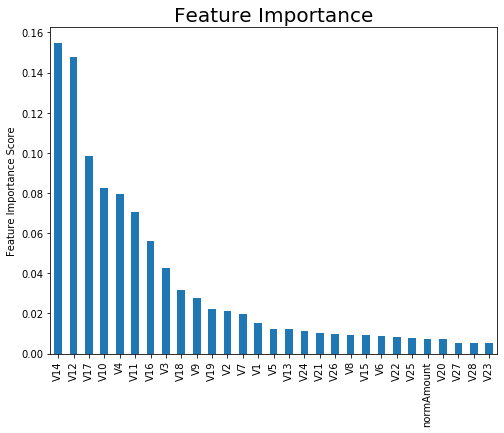

In [45]:
model_vis(model, 'gridsearch 3')

- same as default: max_depth = NONE

### Step 4: n_estimator

In [48]:
grid_params = {
    'n_estimators': range(100,1001,100),
    'max_depth':[50, None]
}

gs4 = GridSearchCV(ExtraTreesClassifier(bootstrap = False, 
                                        class_weight = 'balanced',
                                        random_state = 42),
                   param_grid=grid_params,
                   cv = 5, 
                   n_jobs=4, 
                   verbose=5)

In [49]:
gs4.fit(X_train_sm_sf, y_train_sm_sf.ravel())
gs4.best_params_, gs4.best_score_

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:  8.4min
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed: 110.3min
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed: 200.1min finished


({'max_depth': 50, 'n_estimators': 100}, 0.9999015176003759)

In [50]:
model_grid = ExtraTreesClassifier(max_depth = 50,
                                  n_estimators = 100,
                                  class_weight='balanced', 
                                  random_state = 42)
model = model_grid.fit(X_train_sm_sf,y_train_sm_sf.ravel())

,false_positive_test,false_negative_test,recall_train,recall_test,precision_train,precision_test,roc_train,roc_test
gridsearch 4,4,7,0.960422,0.938053,0.981132,0.963636,0.980195,0.968998


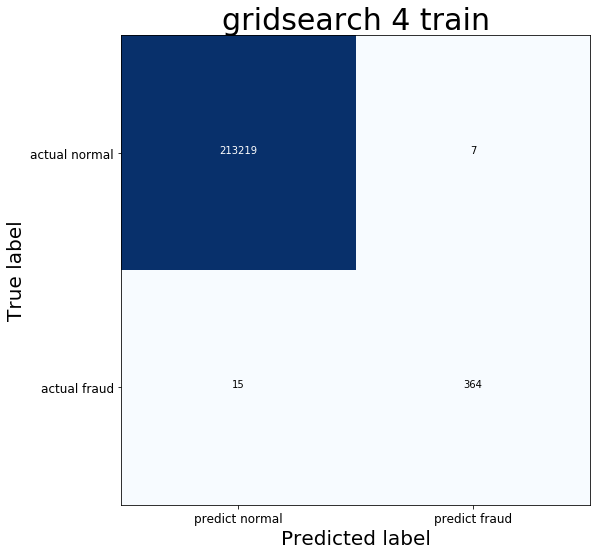

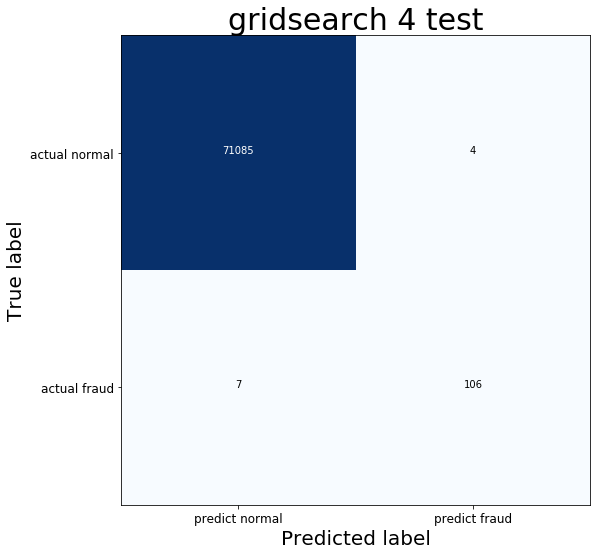

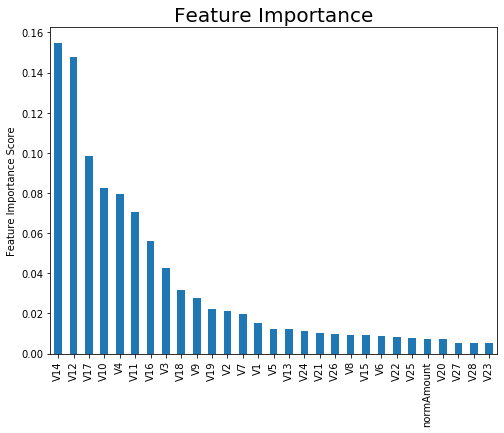

In [51]:
model_vis(model,'gridsearch 4')

### Step 5: max_feature

In [53]:
grid_params = {
   'max_features':['log2','sqrt','auto', 6,7,8,9,10,11]
}

gs5 = GridSearchCV(ExtraTreesClassifier(n_estimators =100,
                                        max_depth = 50,
                                        bootstrap = False, 
                                        class_weight = 'balanced',
                                        random_state = 42),
                   param_grid=grid_params,
                   cv = 5, 
                   n_jobs=4, 
                   verbose=5)

gs5.fit(X_train_sm_sf, y_train_sm_sf.ravel())
gs5.best_params_, gs5.best_score_

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:  5.0min
[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed: 22.5min finished


({'max_features': 11}, 0.9999179314161191)

In [54]:
gs1.best_score_

0.9998991727695554

In [55]:
model_grid = ExtraTreesClassifier(max_features = 11,
                                  max_depth = 50,
                                  n_estimators = 100,
                                  class_weight='balanced', 
                                  random_state = 42)
model = model_grid.fit(X_train_sm_sf,y_train_sm_sf.ravel())

,false_positive_test,false_negative_test,recall_train,recall_test,precision_train,precision_test,roc_train,roc_test
gridsearch 5,6,7,0.957784,0.938053,0.986413,0.946429,0.97888,0.968984


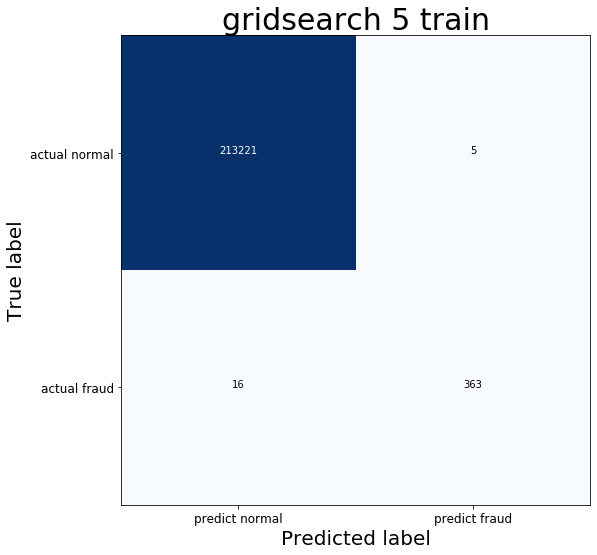

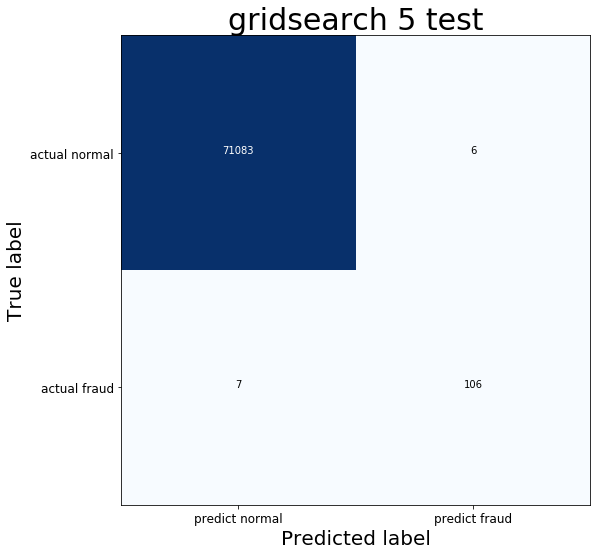

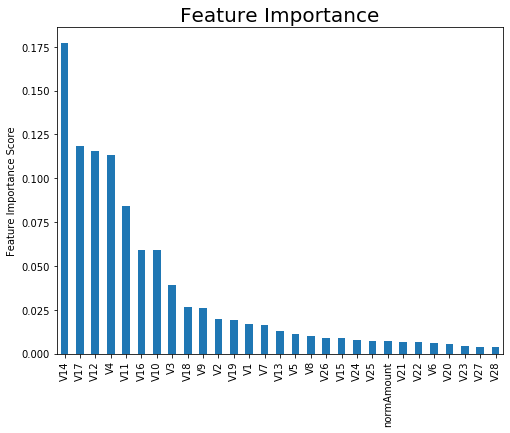

In [56]:
model_vis(model,'gridsearch 5')

- default param is the best performed model